In [1]:
import pandas as pd
import os
!pwd

content=sorted(os.listdir("01012015_01022015/predict/only_dynamic"))
content.remove(".ipynb_checkpoints")


/home/ec2-user/SageMaker/CDEM/CellEnMon/datasets/ims


In [15]:

b394_ts04_NEVATIM = pd.DataFrame(columns=["Time","RainAmout[mm/h]"])
b480_a458_PARAN = pd.DataFrame(columns=["Time","RainAmout[mm/h]"])
j033_261c_NEGBA = pd.DataFrame(columns=["Time","RainAmout[mm/h]"])

for file in content:
    df = pd.read_csv(f"01012015_01022015/predict/only_dynamic/{file}")
    if "b394-ts04-NEVATIM" in file:
        b394_ts04_NEVATIM = pd.concat([b394_ts04_NEVATIM,df], ignore_index=True)
    elif "b480-a458-PARAN" in file:
        b480_a458_PARAN = pd.concat([b480_a458_PARAN,df], ignore_index=True)
    elif "j033-261c-NEGBA" in file:
        j033_261c_NEGBA = pd.concat([j033_261c_NEGBA,df], ignore_index=True)


        
# Replace small fake values with zero
b394_ts04_NEVATIM.loc[b394_ts04_NEVATIM['RainAmout[mm/h]'] <= 0.5, 'RainAmout[mm/h]'] = 0
b480_a458_PARAN.loc[b480_a458_PARAN['RainAmout[mm/h]'] <= 0.5, 'RainAmout[mm/h]'] = 0
j033_261c_NEGBA.loc[j033_261c_NEGBA['RainAmout[mm/h]'] <= 0.5, 'RainAmout[mm/h]'] = 0

# Sort by the 'Time' column in ascending order
b394_ts04_NEVATIM = b394_ts04_NEVATIM.sort_values(by='Time')
b480_a458_PARAN = b480_a458_PARAN.sort_values(by='Time')
j033_261c_NEGBA = j033_261c_NEGBA.sort_values(by='Time')

# Change naming to reflect prediction
b394_ts04_NEVATIM = b394_ts04_NEVATIM.rename(columns={'RainAmout[mm/h]': 'RainAmoutPredicted[mm/h]'})
b480_a458_PARAN = b480_a458_PARAN.rename(columns={'RainAmout[mm/h]': 'RainAmoutPredicted[mm/h]'})
j033_261c_NEGBA = j033_261c_NEGBA.rename(columns={'RainAmout[mm/h]': 'RainAmoutPredicted[mm/h]'})

# Add GT
b394_ts04_NEVATIM["RainAmoutGT[mm/h]"]=pd.read_csv(f"01012015_01022015/processed/NEVATIM_34.922_31.205.csv")["RR[mm/h]"][:len(b394_ts04_NEVATIM)]
b480_a458_PARAN["RainAmoutGT[mm/h]"]=pd.read_csv(f"01012015_01022015/processed/PARAN_35.148_30.367.csv")["RR[mm/h]"][:len(b480_a458_PARAN)]
j033_261c_NEGBA["RainAmoutGT[mm/h]"]=pd.read_csv(f"01012015_01022015/processed/NEGBA_34.681_31.658.csv")["RR[mm/h]"][:len(j033_261c_NEGBA)]


# Replace real values with zero
b394_ts04_NEVATIM.loc[b394_ts04_NEVATIM['RainAmoutGT[mm/h]'] <= 1, 'RainAmoutGT[mm/h]'] = 0
b480_a458_PARAN.loc[b480_a458_PARAN['RainAmoutGT[mm/h]'] <= 1, 'RainAmoutGT[mm/h]'] = 0
j033_261c_NEGBA.loc[j033_261c_NEGBA['RainAmoutGT[mm/h]'] <= 1, 'RainAmoutGT[mm/h]'] = 0


# Accumulative
b394_ts04_NEVATIM["RainAmoutPredictedCumSum"]=b394_ts04_NEVATIM['RainAmoutPredicted[mm/h]'].cumsum()
b394_ts04_NEVATIM["RainAmoutGTCumSum"]=b394_ts04_NEVATIM['RainAmoutGT[mm/h]'].cumsum()

b480_a458_PARAN["RainAmoutPredictedCumSum"]=b480_a458_PARAN['RainAmoutPredicted[mm/h]'].cumsum()
b480_a458_PARAN["RainAmoutGTCumSum"]=b480_a458_PARAN['RainAmoutGT[mm/h]'].cumsum()

j033_261c_NEGBA["RainAmoutPredictedCumSum"]=j033_261c_NEGBA['RainAmoutPredicted[mm/h]'].cumsum()
j033_261c_NEGBA["RainAmoutGTCumSum"]=j033_261c_NEGBA['RainAmoutGT[mm/h]'].cumsum()


# Save to csv
b394_ts04_NEVATIM.to_csv("01012015_01022015/predict/b394_ts04_NEVATIM.csv", index=False)
b480_a458_PARAN.to_csv("01012015_01022015/predict/b480_a458_PARAN.csv", index=False)
j033_261c_NEGBA.to_csv("01012015_01022015/predict/j033_261c_NEGBA.csv", index=False)


/tmp/ipykernel_14066/3418511741.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  b480_a458_PARAN = pd.concat([b480_a458_PARAN,df], ignore_index=True)
/tmp/ipykernel_14066/3418511741.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  j033_261c_NEGBA = pd.concat([j033_261c_NEGBA,df], ignore_index=True)


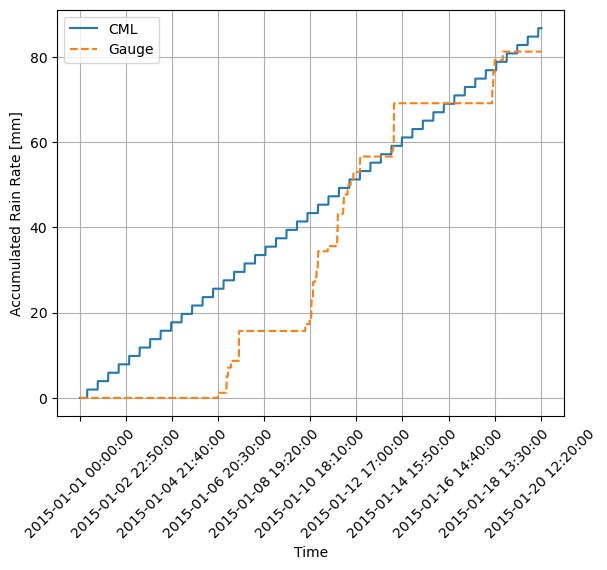

In [16]:
import matplotlib.pyplot as plt
import numpy as np

excel_data=j033_261c_NEGBA

fake = np.asarray(excel_data["RainAmoutPredictedCumSum"])
real = np.asarray(excel_data["RainAmoutGTCumSum"])

mmax=np.max(np.asarray(excel_data["RainAmoutGT[mm/h]"]))

time=np.asarray(excel_data.Time)
plt.plot(time, fake, label="CML")
plt.plot(time, real, "--", label="Gauge")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Accumulated Rain Rate [mm]")
plt.legend()
plt.tight_layout()

# Specify the number of ticks you want on the x-axis
num_ticks = 10

# Calculate the step size between ticks
step_size = len(time) // num_ticks

# Set the ticks on the x-axis
plt.xticks(time[::step_size], rotation=45)

plt.show()

In [6]:
plt.savefig("epoch_1k_j033_261c_NEGBA_cml_vs_gauge.svg")
print(mmax)

8.2


<Figure size 640x480 with 0 Axes>